# Import & Configuration

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

In [96]:
pd.set_option('max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [97]:
PATH_TO_DATA = '../data/raw'

# Class for EDA

In [488]:
class Frame:
    def __init__(self, path_to_df, index_col=None, parse_dates=None, target=None):
        self._df = pd.read_csv(os.path.join(PATH_TO_DATA, path_to_df), index_col=index_col, parse_dates=parse_dates)
        self._target = target
        self._cat_features = []
        self._num_features = []
        self._bin_features = []
        self._init_feat_descriptors()
        
    def _init_feat_descriptors(self):
        for feat in self.df.columns:
            if self.df[feat].dtypes == 'O':
                self._cat_features.append(feat)
            else:
                self._num_features.append(feat)
            if self.df[feat].nunique() == 2:
                self._bin_features.append(feat)
    
    @property
    def target(self):
        return self._target
    
    @property
    def df(self):
        return self._df
    
    @property
    def cat_features(self):
        return self._cat_features
    
    @property
    def num_features(self):
        return self._num_features
    
    @property
    def bin_features(self):
        return self._bin_features
    
    def count_NaN(self):
        for col in self.df.columns:
            qty_nan = sum(self.df[col].isna())
            if qty_nan == 0:
                print(f"{col} is entire")
            else:
                print(f"{col} has {qty_nan} NaN values")
                
    def count_unique(self):
        print(f'There are {self.df.isnull().any().sum()} columns in dataset ' + 
              f'with missing values from {self.df.shape[1]}.')
        for col in self.df.columns:
            qty_unq = len(self.df[col].unique())
            print(f"{col} has {qty_unq} unique values")
    
    def info(self):
        return self.df.info()
    
    def describe(self, include=None):
        return self.df.describe(include=include)
    
    def shrink(self):
        for col in self.num_features:
            if str(self.df[col].dtype).startswith('float'):
                self.df[col] = pd.to_numeric(self.df[col], downcast='float', errors='ignore')
            elif str(self.df[col].dtype).startswith('date'):
                continue
            else:
                self.df[col] = pd.to_numeric(self.df[col], downcast='integer', errors='ignore')
                
    

In [148]:
class EDA:
    def __init__(self, frame):
        self._frame = frame
        
    @property
    def frame(self):
        return self._frame
    
    def numeric_plot(self, interactive=False, features='all'):
        if features == 'all':
            features = self.frame.cat_features
        elif isinstance(features, list):
            features = features
        else:
            return
        if not interactive:
            plt.figure(figsize=(16, 32))
            i = 1
            for feat in features:
                rows = len(self.frame.num_features)
                plt.subplot(rows, 2, i)
                sns.distplot(self.frame.df[feat], bins=50)
                plt.title(f'Distribution of {feat}');
                plt.subplot(rows, 2, i + 1)
                sns.violinplot(self.frame.df[feat])
                plt.title(f'Violin of {feat}');
                i += 2
                print(self.frame.df[feat].value_counts().sort_values(ascending=False).head(10), end='\n\n')
                
    def cat_plot(self, interactive=False, features='all'):
        if features == 'all':
            features = self.frame.cat_features
        elif isinstance(features, list):
            features = features
        else:
            return
        if not interactive:
            plt.figure(figsize=(16, 32))
            for i, feat in enumerate(features):
                plt.subplot(len(features), 1, i + 1)
                g = sns.countplot(self.frame.df[feat])
                g.set_xticklabels(g.get_xticklabels(),rotation=90)
                plt.title(f'Distribution of {feat}');
                plt.subplots_adjust(wspace = 0.2, hspace = 1.3,top = 0.9)
                print(self.frame.df[feat].value_counts().sort_values(ascending=False).head(10), end='\n\n')

# Clients lookup

In [129]:
clients = Frame('clients.csv', index_col='client_id')

In [130]:
clients.describe(include='all')

,first_issue_date,first_redeem_date,age,gender
count,400162,364693,400162.000000,400162
unique,396725,362527,NaN,3
top,2017-08-04 19:37:41,2017-12-29 17:00:11,NaN,U
freq,3,3,NaN,185706
mean,NaN,NaN,46.488112,NaN
std,NaN,NaN,43.871218,NaN
min,NaN,NaN,-7491.000000,NaN
25%,NaN,NaN,34.000000,NaN
50%,NaN,NaN,45.000000,NaN
75%,NaN,NaN,59.000000,NaN


In [131]:
clients.cat_features, clients.num_features

(['first_issue_date', 'first_redeem_date', 'gender'], ['age'])

In [132]:
clients.count_NaN()
print("--------------------------------")
clients.count_unique()

first_issue_date is entire
first_redeem_date has 35469 NaN values
age is entire
gender is entire
--------------------------------
There are 1 columns in dataset with missing values from 4.
first_issue_date has 396725 unique values
first_redeem_date has 362528 unique values
age has 290 unique values
gender has 3 unique values


33    9437
36    9394
32    9354
31    9286
35    9152
34    9119
37    8653
40    8648
38    8633
59    8460
Name: age, dtype: int64



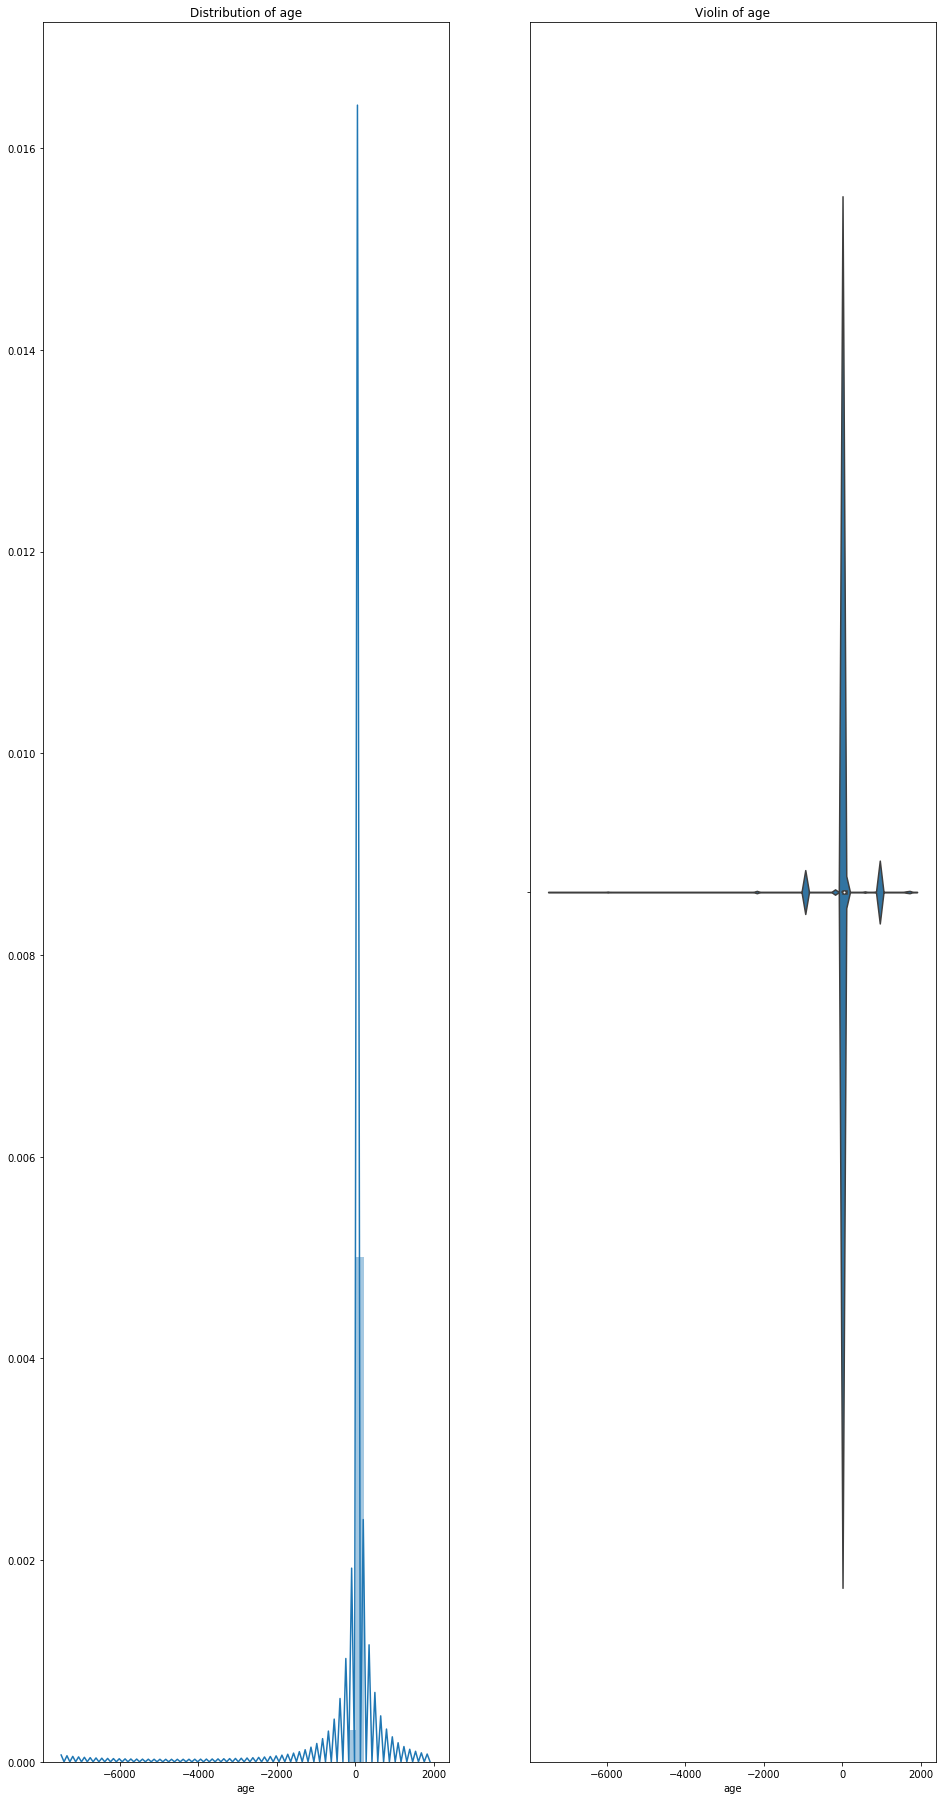

In [133]:
clients_EDA = EDA(clients)
clients_EDA.cat_plot(['gender'])
clients_EDA.numeric_plot()

In [134]:
clients.df['age'].describe()

count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

## Work with numeric features

In [99]:
clients[clients['age'] <= 0].shape[0], clients[clients['age'] > 90].shape[0], clients.shape[0]

(138, 1139, 400162)

In [107]:
# age has invalid values below 0 and above 90

# Products lookup

In [142]:
products = Frame('products.csv', index_col='product_id')

print(products.cat_features, products.num_features, products.bin_features)

['level_1', 'level_2', 'level_3', 'level_4', 'brand_id', 'vendor_id'] ['segment_id', 'netto', 'is_own_trademark', 'is_alcohol'] ['is_own_trademark', 'is_alcohol']


In [144]:
products.count_NaN()
print("------------------------")
products.count_unique()

level_1 has 3 NaN values
level_2 has 3 NaN values
level_3 has 3 NaN values
level_4 has 3 NaN values
segment_id has 1572 NaN values
brand_id has 5200 NaN values
vendor_id has 34 NaN values
netto has 3 NaN values
is_own_trademark is entire
is_alcohol is entire
------------------------
There are 8 columns in dataset with missing values from 10.
level_1 has 4 unique values
level_2 has 43 unique values
level_3 has 202 unique values
level_4 has 791 unique values
segment_id has 117 unique values
brand_id has 4297 unique values
vendor_id has 3194 unique values
netto has 781 unique values
is_own_trademark has 2 unique values
is_alcohol has 2 unique values


e344ab2e71    22183
c3d3a8e8c6    16573
ec62ce61e3     4279
Name: level_1, dtype: int64

52f13dac0c    8891
ad2b2e17d2    6631
f2333c90fb    3310
ed2ad1797c    3257
703f4b6eb0    2396
749c619457    2393
14d373dff5    2377
c2a3ea8d5e    2209
1d2939ba1d    1717
f93982269d    1343
Name: level_2, dtype: int64

ca69ed9de2    3737
419bc5b424    2729
0f84eb7480    2571
38816369ce    2324
6b55683dad    1862
d3cfe81323    1437
0bcfc6519b    1306
a6b0dd76e0    1033
e33cc0b2a4    1001
eda7b2976b     889
Name: level_3, dtype: int64

105.0    5360
150.0    2745
271.0    1690
259.0    1523
85.0     1291
148.0    1073
1.0       912
157.0     876
263.0     873
321.0     848
Name: segment_id, dtype: int64



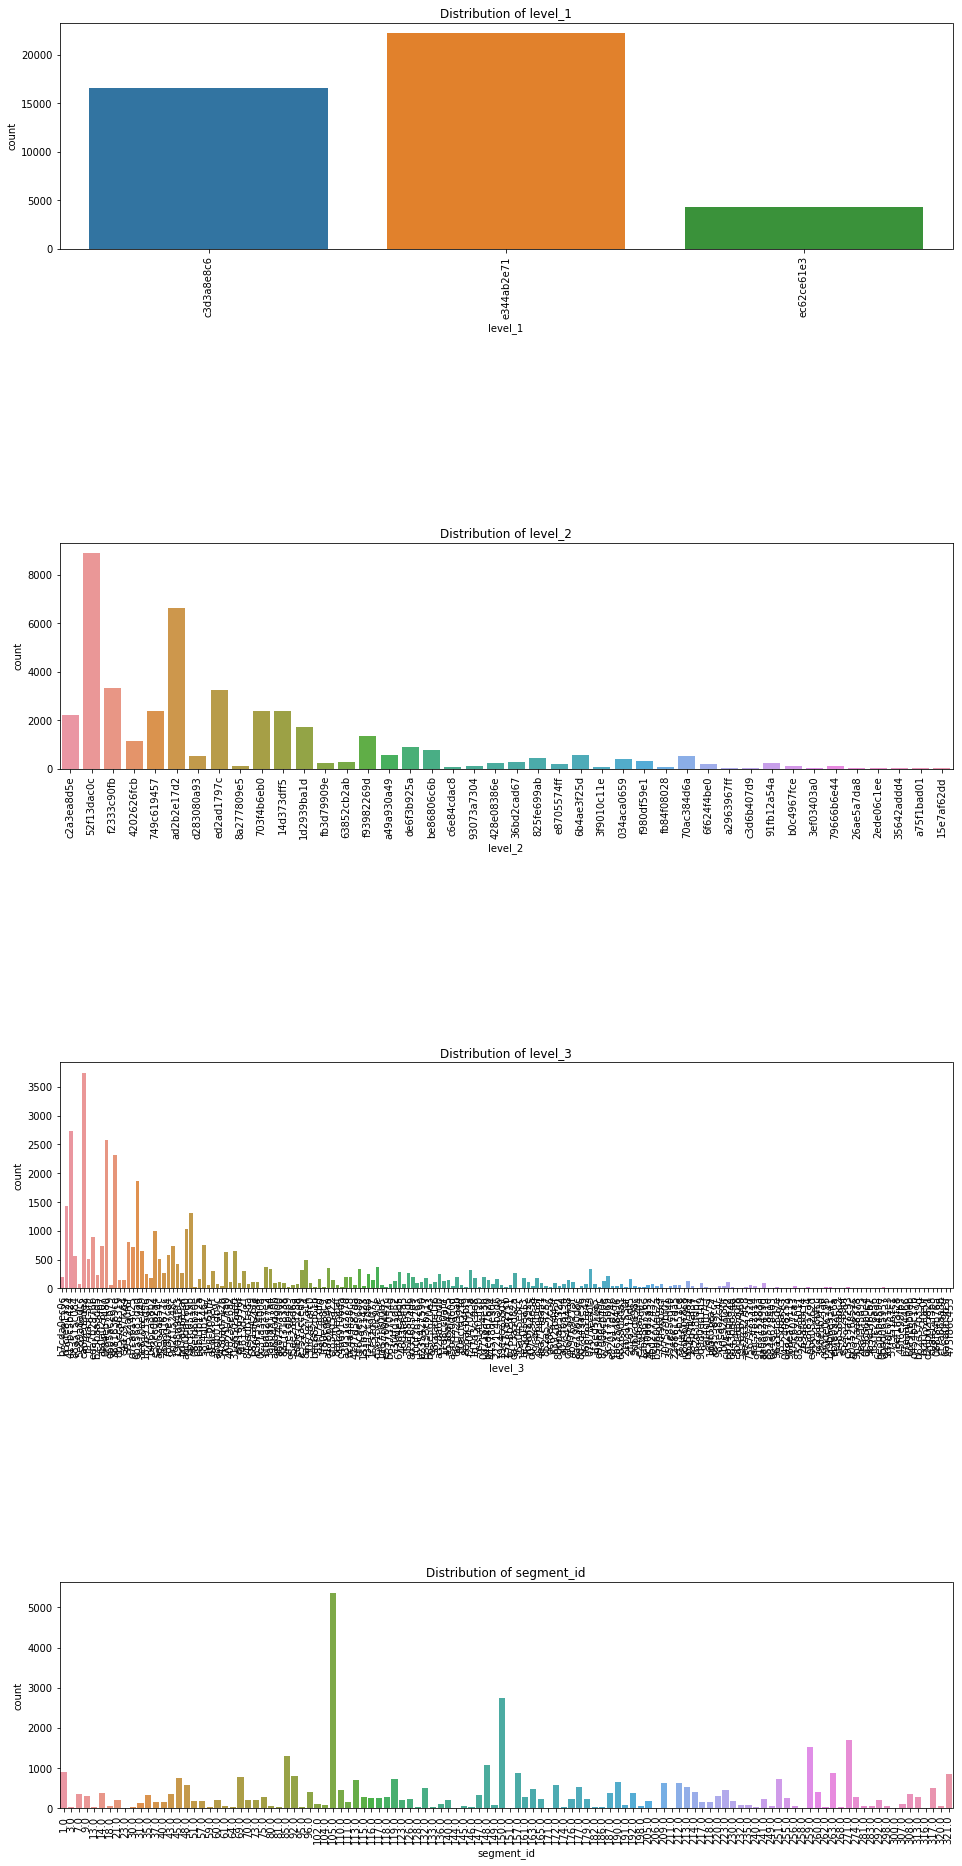

In [150]:
products_eda = EDA(cl)
products_eda.cat_plot(features=['level_1', 'level_2', 'level_3', 'segment_id'])

0.50    4256
1.00    2953
0.40    2491
0.20    2410
0.30    2354
0.10    1988
0.25    1835
0.35    1330
0.45    1256
0.15    1074
Name: netto, dtype: int64



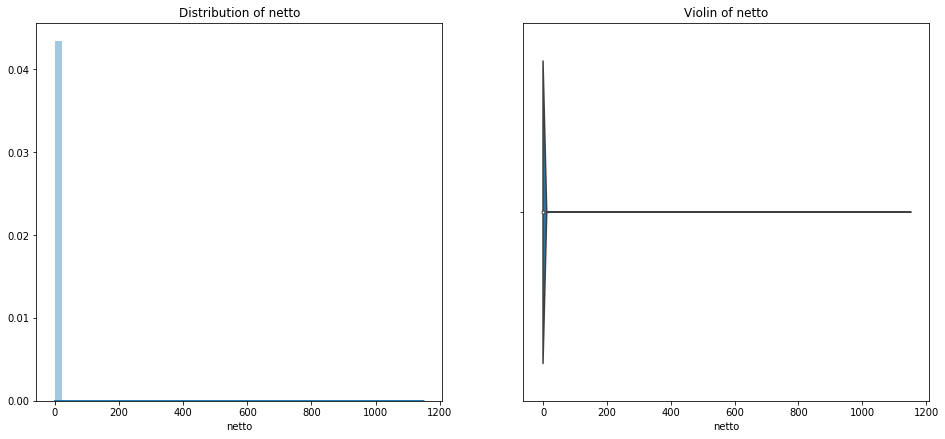

In [151]:
products_eda.numeric_plot(features=['netto'])

## Numeric feature

In [269]:
products[products['netto'] > 4].shape[0], products[products['netto'] <= 4].shape[0]

(105, 42933)

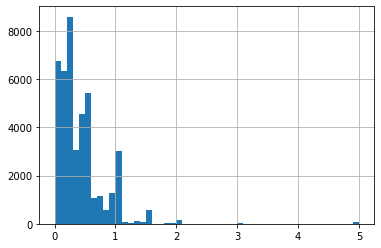

In [264]:
products[products['netto'] <= 5]['netto'].hist(bins=50);

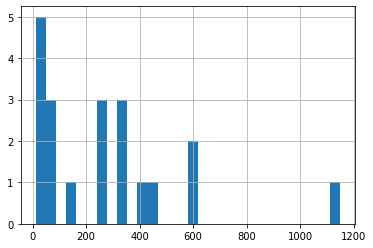

In [267]:
products[products['netto'] > 10]['netto'].hist(bins=30);

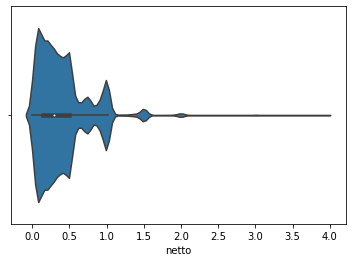

In [270]:
sns.violinplot(products[products['netto'] <= 4]['netto']);

## Level features

In [271]:
level_feat = []
for col in products.columns:
    if col.startswith('level'):
        level_feat.append(col)

In [280]:
bad_products = products[products['level_1'].isna()].index
bad_products

Index(['04d86b4b50', '48cc0e256d', '6a3d708544'], dtype='object', name='product_id')

In [281]:
products.drop(bad_products, inplace=True)

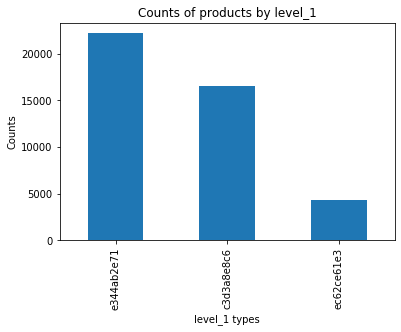

In [292]:
ax = products[level_feat[0]].value_counts().plot(kind='bar', title='Counts of products by level_1');
ax.set_xlabel("level_1 types");
ax.set_ylabel("Counts");

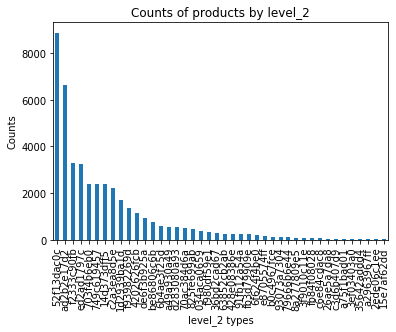

In [293]:
ax = products[level_feat[1]].value_counts().plot(kind='bar', title='Counts of products by level_2');
ax.set_xlabel("level_2 types");
ax.set_ylabel("Counts");

## ID Features

In [298]:
id_feat = []
for col in products.columns:
    if col.endswith('id'):
        id_feat.append(col)

In [301]:
for feat in id_feat:
    products[feat].fillna("NA_ID", inplace=True)

In [319]:
print(f"TOP10 distribution for {id_feat[0]}")
products[id_feat[0]].value_counts()[:10]

TOP10 distribution for segment_id


105.0    5360
150.0    2745
271.0    1690
NA_ID    1569
259.0    1523
85.0     1291
148.0    1073
1.0       912
157.0     876
263.0     873
Name: segment_id, dtype: int64

# Purchases lookup

In [203]:
target = pd.read_csv(os.path.join(PATH_TO_DATA, 'uplift_train.csv'), index_col='client_id')

In [489]:
purchases = Frame(('purchases.csv'), parse_dates=['transaction_datetime'], index_col=0)

In [490]:
purchases.shrink()

In [491]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
client_id                  object
transaction_id             object
transaction_datetime       datetime64[ns]
regular_points_received    float32
express_points_received    float32
regular_points_spent       float32
express_points_spent       float32
purchase_sum               float32
store_id                   object
product_id                 object
product_quantity           float32
trn_sum_from_iss           float32
trn_sum_from_red           float32
dtypes: datetime64[ns](1), float32(8), object(4)
memory usage: 3.4+ GB


In [492]:
purchases.df.head(5)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [493]:
purchases.df.describe(include='all')

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
count,45786568,45786568,45786568,4.578657e+07,4.578657e+07,4.578657e+07,4.578657e+07,4.578657e+07,45786568,45786568,4.578657e+07,4.578657e+07,3.043356e+06
unique,400162,8045201,4260251,NaN,NaN,NaN,NaN,NaN,13882,42530,NaN,NaN,NaN
top,7a73214c0b,f9a45c98e1,2019-02-07 15:12:53,NaN,NaN,NaN,NaN,NaN,cfbbd53ab7,4009f09b04,NaN,NaN,NaN
freq,2513,116,150,NaN,NaN,NaN,NaN,NaN,18984,1824586,NaN,NaN,NaN
first,NaN,NaN,2018-11-21 21:02:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-03-18 23:40:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,6.886329e+00,6.084099e-02,-5.304835e+00,-3.181049e-01,6.389415e+02,NaN,NaN,7.930188e-01,5.875556e+01,7.670548e+01
std,NaN,NaN,NaN,1.195104e+01,2.425819e+00,3.559064e+01,3.279348e+00,7.569911e+02,NaN,NaN,3.126700e+00,8.423547e+01,8.416062e+01
min,NaN,NaN,NaN,0.000000e+00,0.000000e+00,-5.066000e+03,-3.000000e+02,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.860000e+02,NaN,NaN,1.000000e+00,3.000000e+01,3.100000e+01


## Purchases analytics

In [494]:
purchases.df['date'] = purchases.df['transaction_datetime'].dt.date

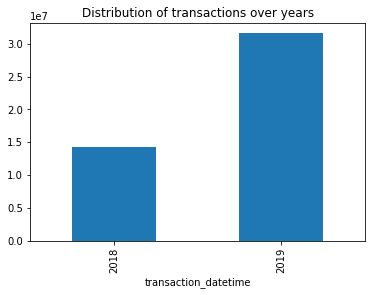

In [495]:
purchases.df['transaction_datetime'].groupby(purchases.df['transaction_datetime'].dt.year).count().plot(kind='bar');
plt.title("Distribution of transactions over years");

In [515]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(y=purchases.df.groupby([purchases.df['transaction_datetime'].dt.date]).count().iloc[:, 0],
                 x=purchases.df['transaction_datetime'].dt.date.unique())])
fig.update_layout(
    title="Distribution of puchases over days",
    xaxis_title="Days",
    yaxis_title="Number of transactions",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [497]:
old_clients = set(purchases.df[purchases.df['transaction_datetime'].dt.year == 2018]['client_id'].values)
len(old_clients), clients.df.shape[0]

(338156, 400162)

In [499]:
proved_clients = old_clients.intersection(set(purchases.df[purchases.df['transaction_datetime'].dt.year == 2019]['client_id'].values))
len(proved_clients)

338156

all clients that have transactions in 2018 are still loyal at 2019

In [514]:
# clients without purchases for last 2 month
sum(purchases.df.groupby('client_id')['transaction_datetime'].max() < '2019-01-18')

0

In [521]:
#last 3 weeks
sum(purchases.df.groupby('client_id')['transaction_datetime'].max() < '2019-02-26')

4994

all clients are regular customers

In [530]:
sleeping_clients = clients.df[purchases.df.groupby('client_id')['transaction_datetime']\
                              .max() < '2019-02-26'].index.to_list()
len(sleeping_clients)

4994

## First conclusions

<ul>
    <li>All clients are loyal and there is no need to clean them. In case of emergency we could cluster them for sleeping/active</li>
    <li>Distribution of transactions over time(days) is similar. But looks suspiciously that on 14 February there was so many transactions, but no of top 15 products was alcohol. And, by the way, that was Thursday. Things to explore -> distribution over weekends and cluster customers that by products that time. Cluster time of day in transactions.</li>
    <lo></lo>
</ul>

# Aggregative features

## mean()

In [175]:
df_agg = purchases.df.groupby('client_id').mean()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,
000012768d,7.551923,0.000000,0.000000,0.0,784.788452,1.038462,53.942307,NaN
000036f903,2.150000,2.222222,0.000000,0.0,362.746918,1.043210,60.555557,NaN
000048b7a6,3.907143,0.000000,0.000000,0.0,530.785706,1.625000,64.589287,NaN
000073194a,6.326829,0.000000,-7.024390,0.0,764.877075,1.548780,116.024391,21.833334
00007c7133,5.538554,0.000000,-20.240963,0.0,650.586975,1.000000,78.168678,78.857140


In [304]:
def plot_num_target(feat):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.violinplot(y=df_agg[feat], x=df_agg['target'])
    plt.title(f'Distribution of {feat}');
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_agg[feat], x=df_agg['treatment'], hue=df_agg['target_2']);
    plt.title(f'Boxes of {feat}');

In [307]:
df_agg.columns

Index(['regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent', 'purchase_sum',
       'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red', 'target',
       'target_2', 'treatment'],
      dtype='object')

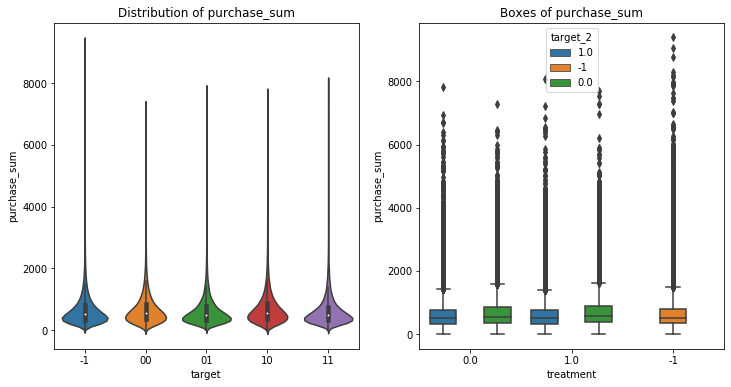

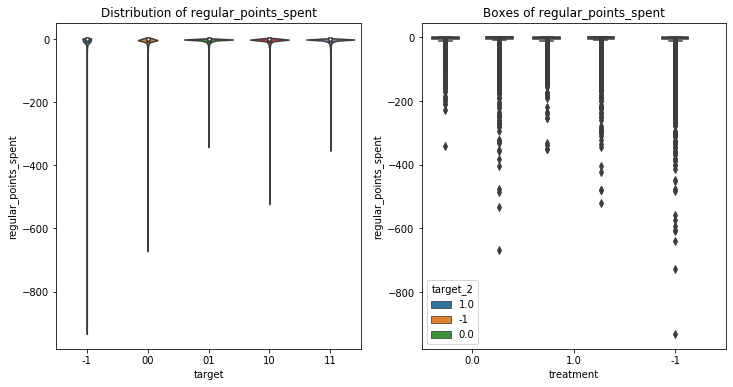

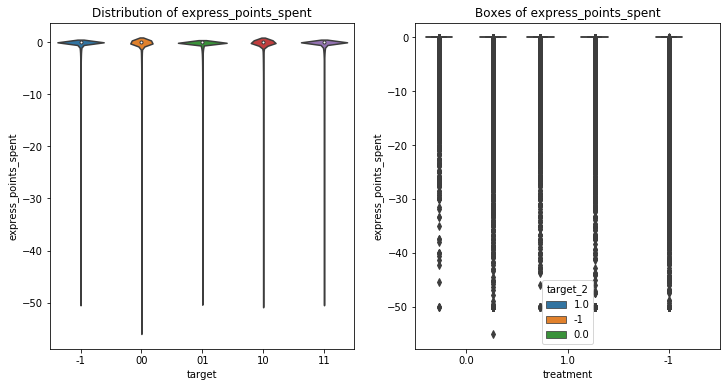

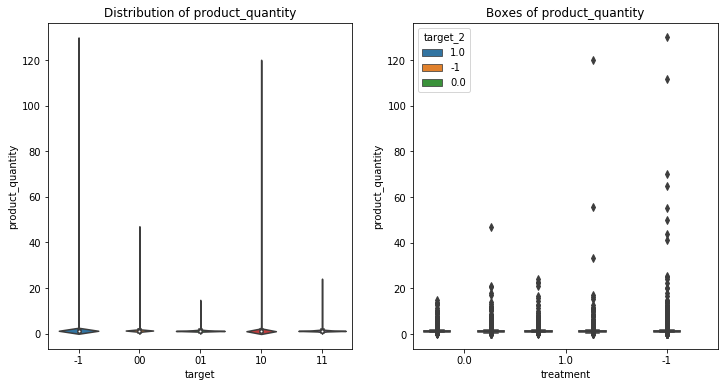

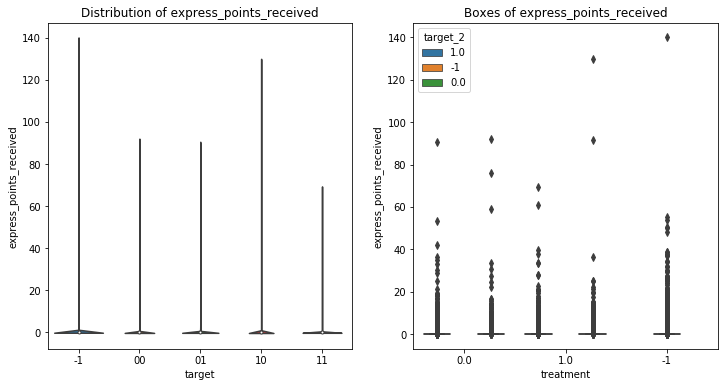

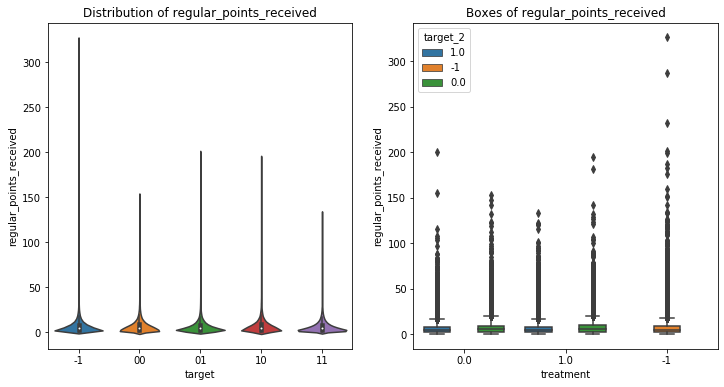

In [312]:
for feat in ['purchase_sum', 'regular_points_spent', 'express_points_spent',
             'product_quantity', 'express_points_received', 'regular_points_received', ]:
    plot_num_target(feat)

## sum()

In [315]:
df_agg = purchases.df.groupby('client_id').sum()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red,target,target_2,treatment
client_id,,,,,,,,,,,
000012768d,392.700012,0.0,0.0,0.0,40809.000000,54.0,2805.0,0.0,01,1,0
000036f903,348.299988,360.0,0.0,0.0,58765.000000,169.0,9810.0,0.0,11,1,1
000048b7a6,218.800003,0.0,0.0,0.0,29724.000000,91.0,3617.0,0.0,-1,-1,-1
000073194a,518.799988,0.0,-576.0,0.0,62719.921875,127.0,9514.0,131.0,-1,-1,-1
00007c7133,459.699982,0.0,-1680.0,0.0,53998.718750,83.0,6488.0,552.0,-1,-1,-1


In [317]:
basic_columns = ['regular_points_received', 'express_points_received',
                 'regular_points_spent', 'express_points_spent', 'purchase_sum',
                 'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']

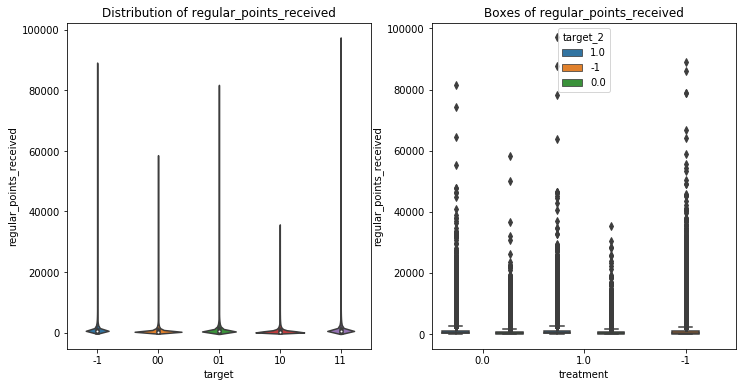

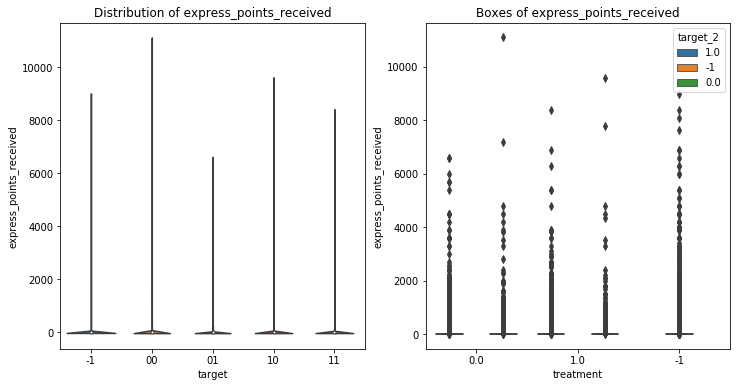

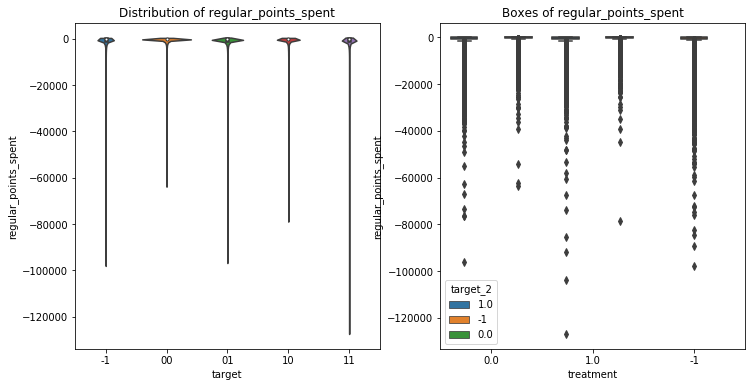

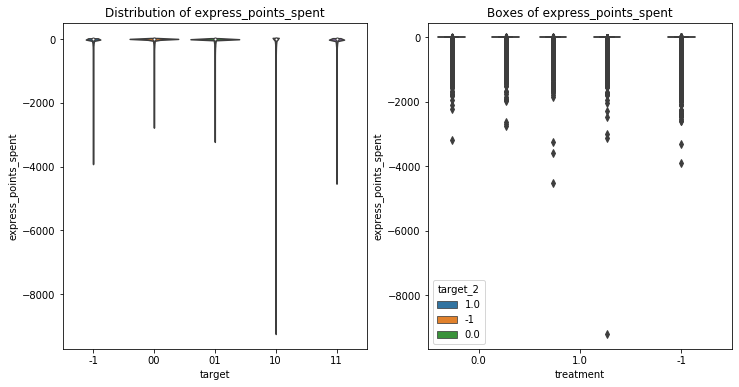

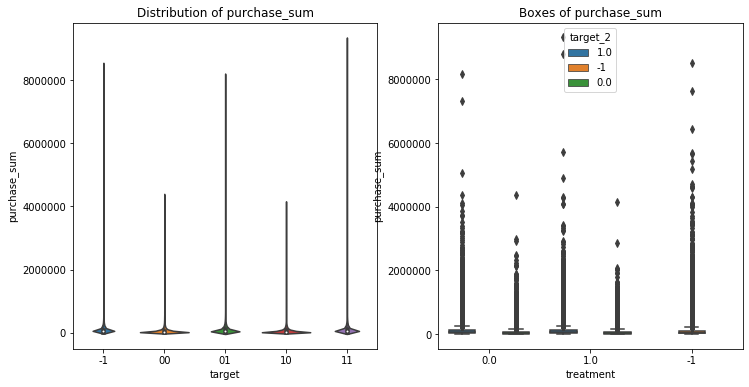

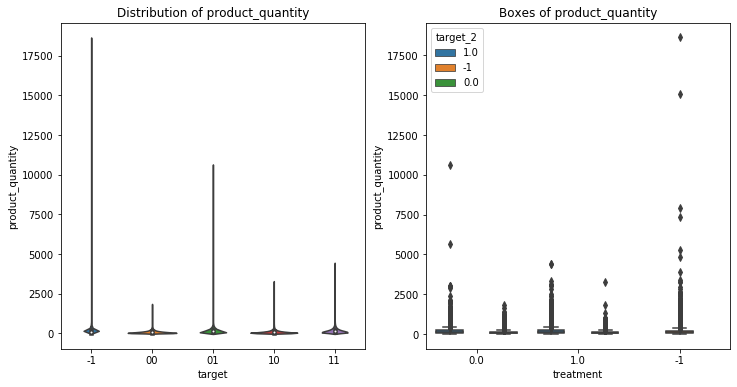

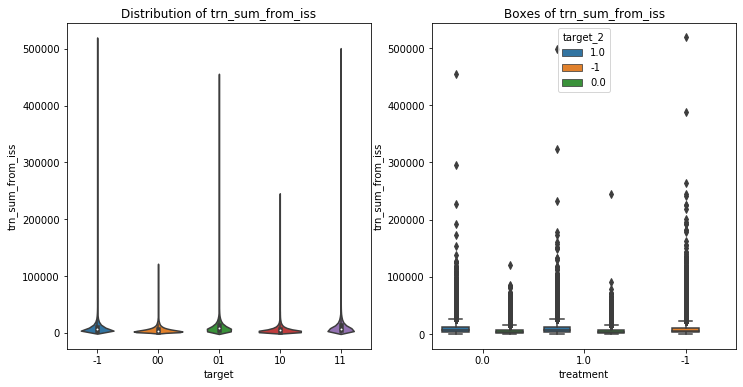

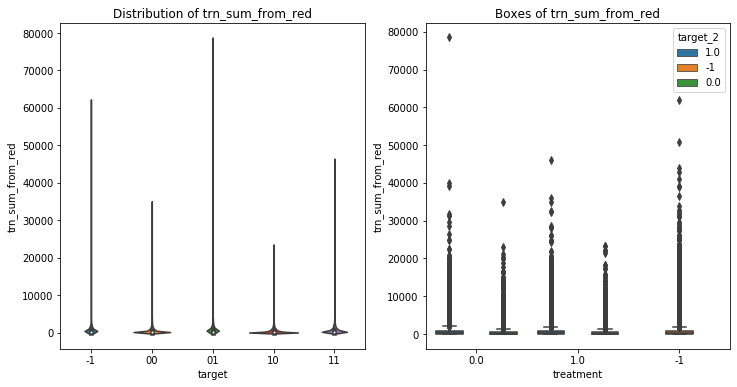

In [319]:
for feat in basic_columns:
    plot_num_target(feat)

## std()

In [320]:
df_agg = purchases.df.groupby('client_id').std()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red,target,target_2,treatment
client_id,,,,,,,,,,,
000012768d,2.581039,0.00000,0.000000,0.0,209.342789,0.558764,33.051006,NaN,01,1,0
000036f903,1.689583,11.36629,0.000000,0.0,160.472061,0.526901,40.982498,NaN,11,1,1
000048b7a6,3.449472,0.00000,0.000000,0.0,324.459381,0.843424,62.332184,NaN,-1,-1,-1
000073194a,5.369094,0.00000,25.153835,0.0,468.586945,1.134775,129.010666,8.084966,-1,-1,-1
00007c7133,3.569376,0.00000,67.099777,0.0,264.245361,0.584349,107.129715,78.007324,-1,-1,-1


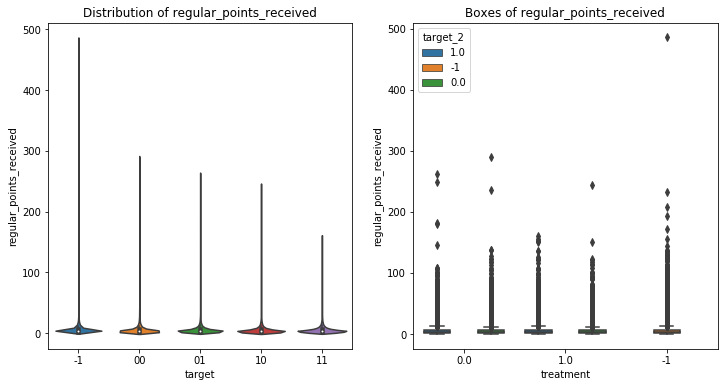

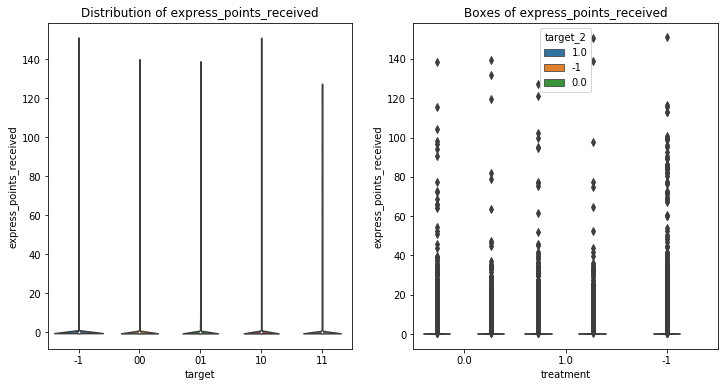

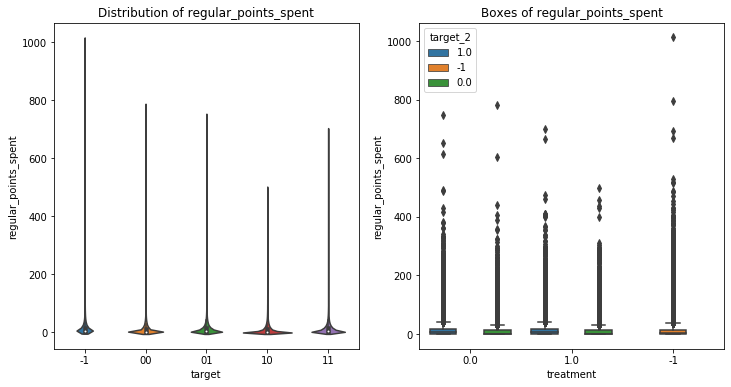

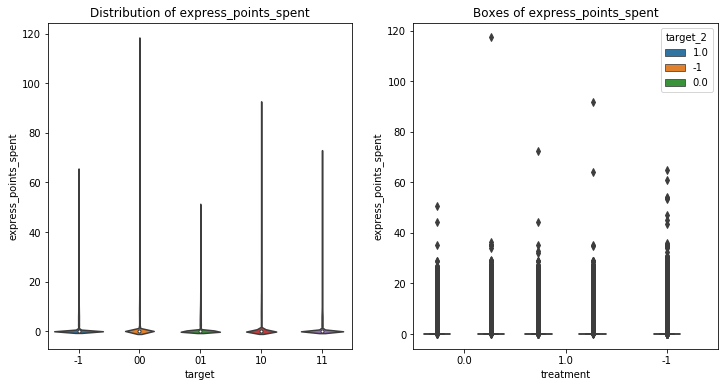

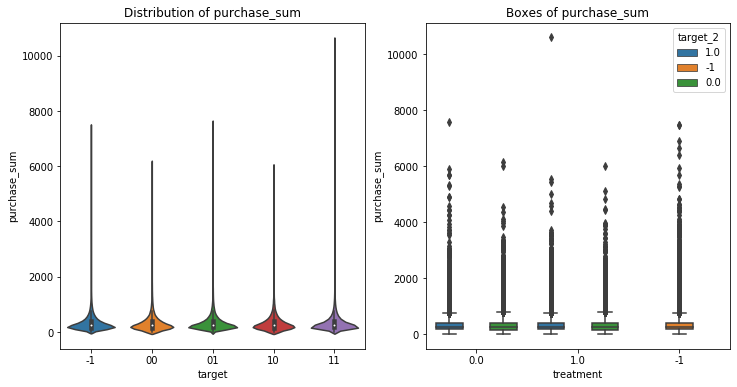

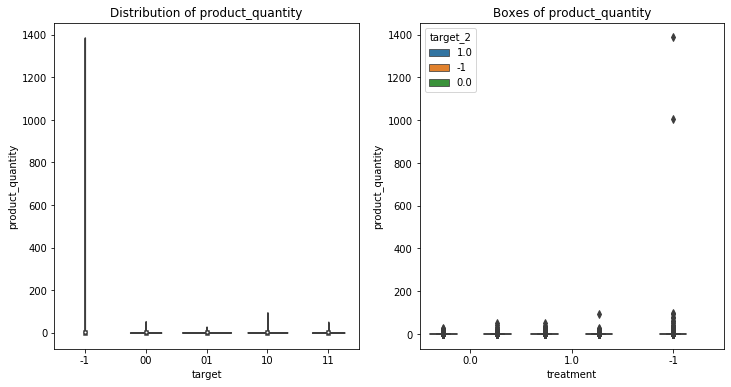

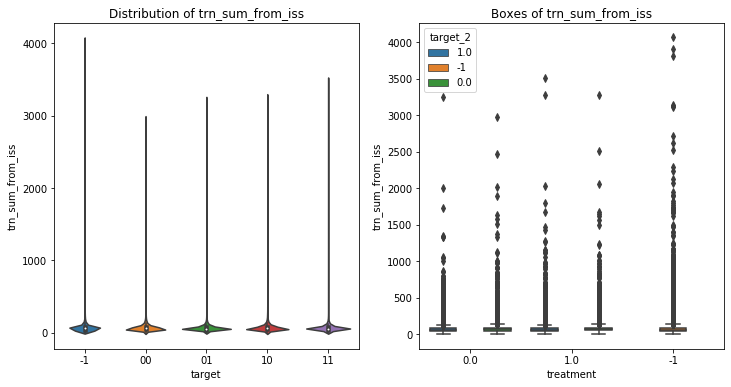

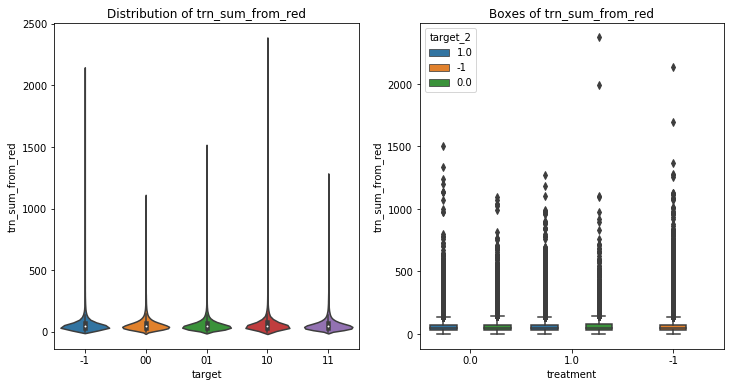

In [321]:
for feat in basic_columns:
    plot_num_target(feat)

## median()

In [322]:
df_agg = purchases.df.groupby('client_id').median()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red,target,target_2,treatment
client_id,,,,,,,,,,,
000012768d,8.0,0.0,0.0,0.0,803.000000,1.0,50.0,NaN,01,1,0
000036f903,1.6,0.0,0.0,0.0,328.000000,1.0,54.5,NaN,11,1,1
000048b7a6,2.3,0.0,0.0,0.0,474.500000,1.0,45.0,NaN,-1,-1,-1
000073194a,4.9,0.0,0.0,0.0,746.640015,1.0,82.5,20.5,-1,-1,-1
00007c7133,7.2,0.0,0.0,0.0,729.000000,1.0,43.0,55.0,-1,-1,-1


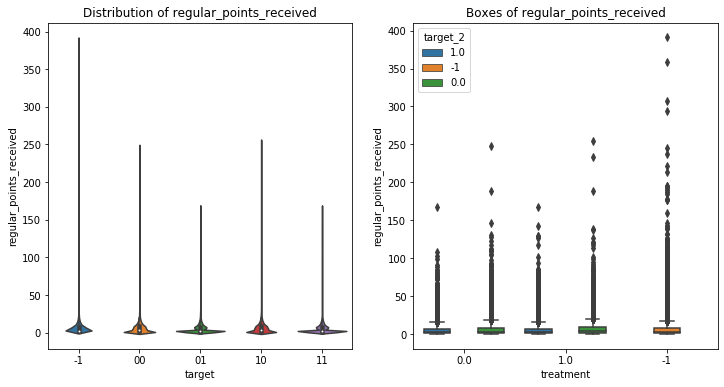

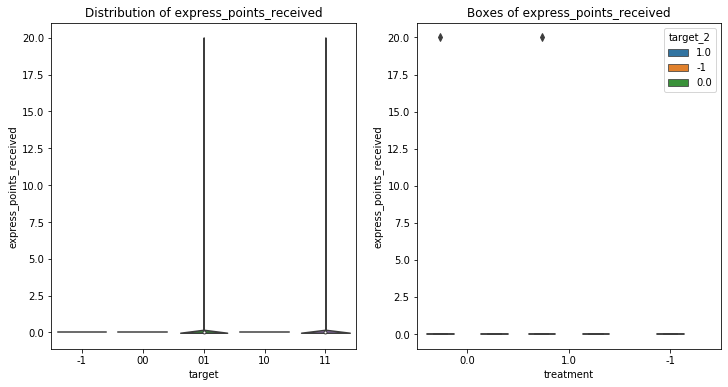

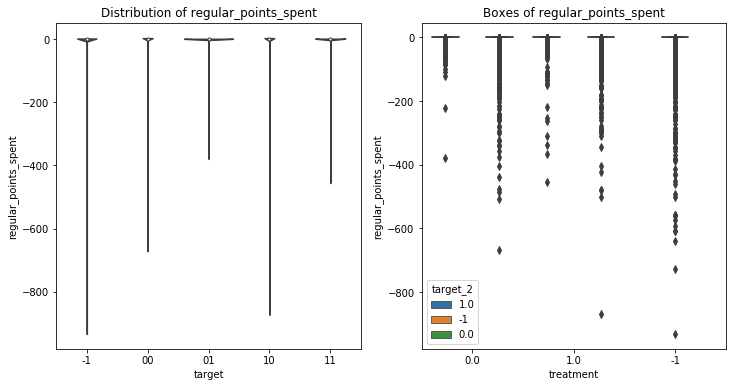

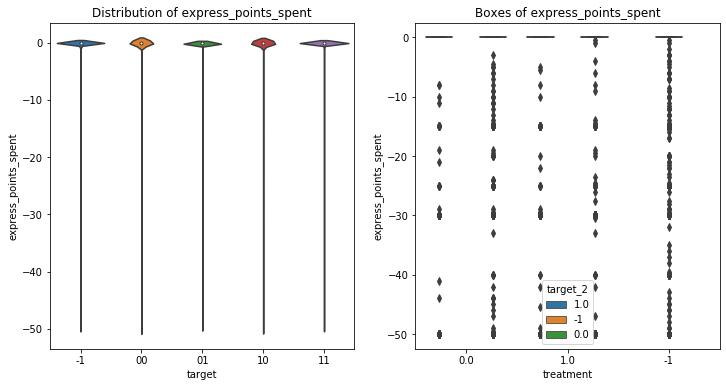

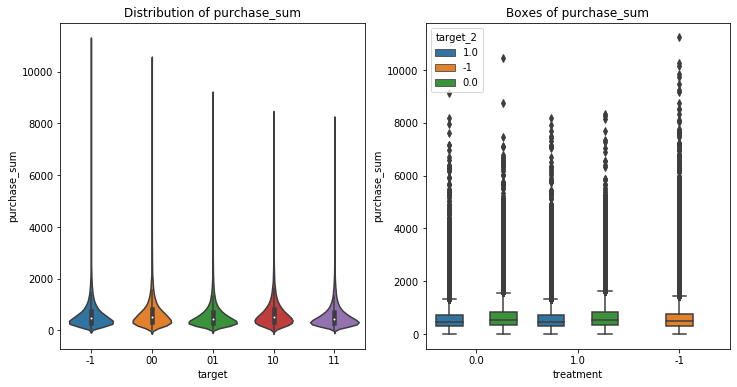

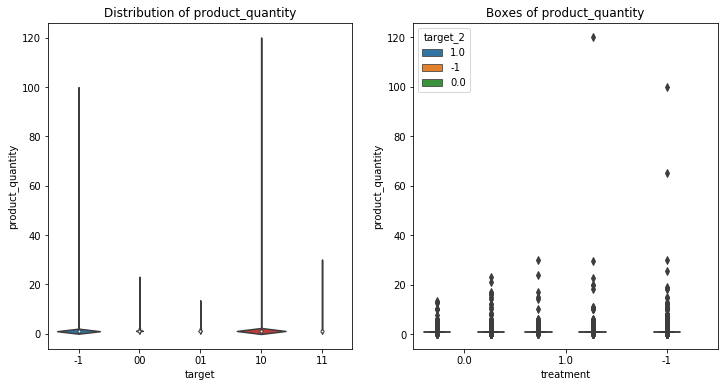

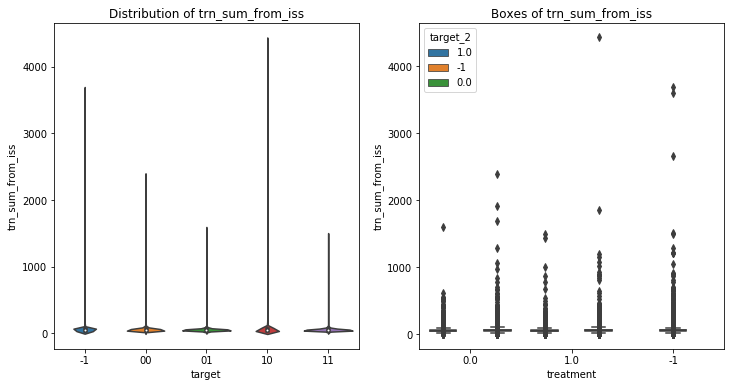

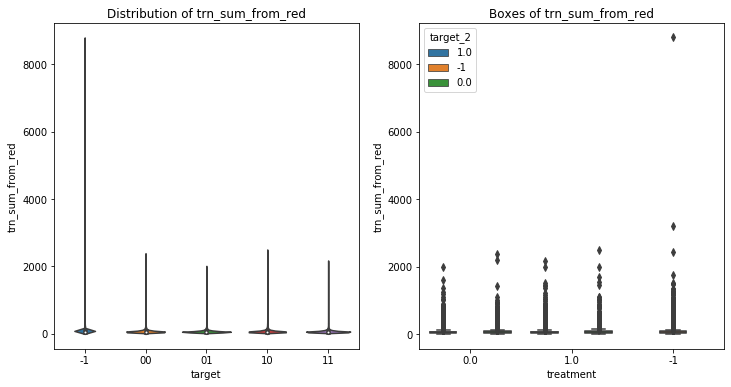

In [323]:
for feat in basic_columns:
    plot_num_target(feat)

## range()

In [333]:
df_agg = purchases.df.groupby('client_id')[basic_columns].min()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red,target,target_2,treatment
client_id,,,,,,,,,,,
000012768d,2.0,0.0,0.0,0.0,419.000000,0.0,0.0,NaN,01,1,0
000036f903,0.2,0.0,0.0,0.0,58.000000,0.0,0.0,NaN,11,1,1
000048b7a6,0.5,0.0,0.0,0.0,113.000000,0.0,0.0,NaN,-1,-1,-1
000073194a,0.1,0.0,-96.0,0.0,130.839996,0.0,0.0,14.0,-1,-1,-1
00007c7133,1.5,0.0,-240.0,0.0,319.000000,0.0,0.0,31.0,-1,-1,-1


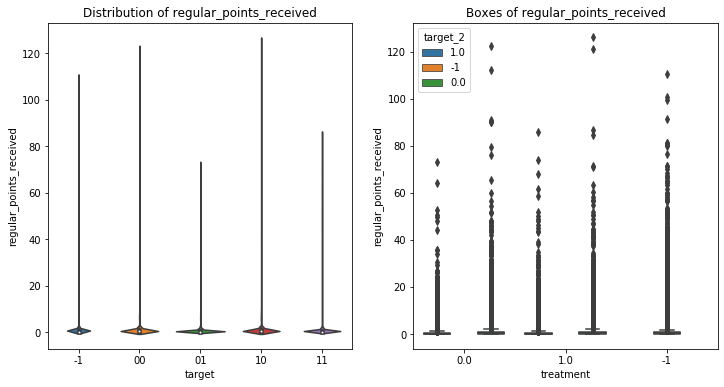

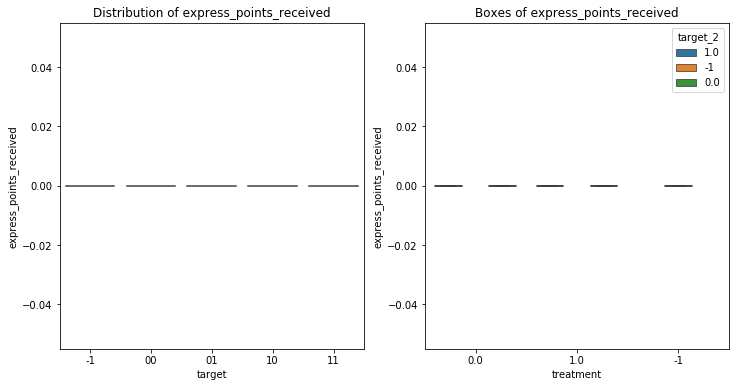

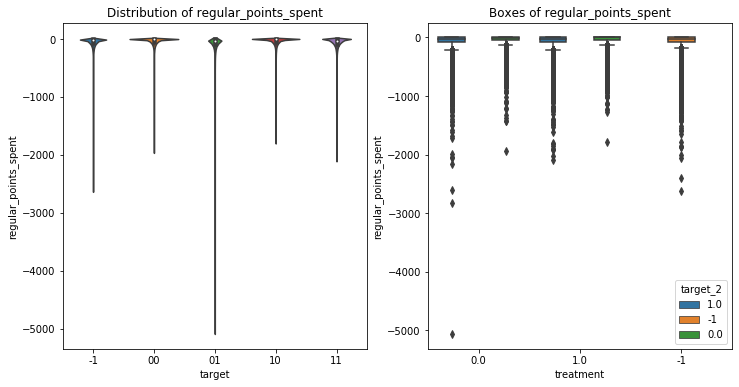

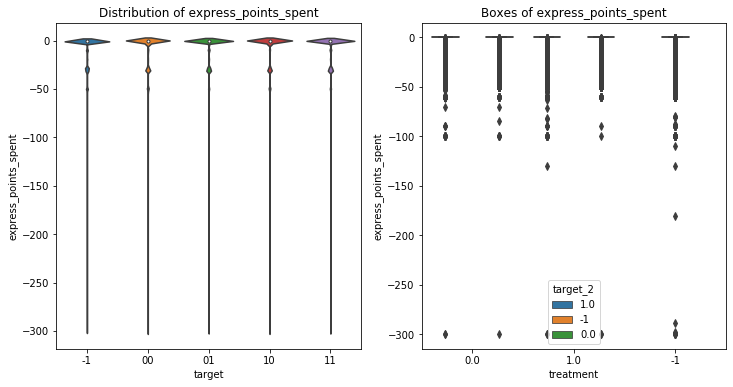

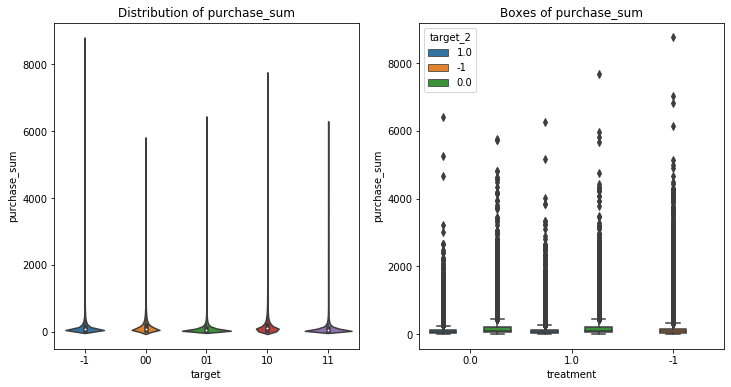

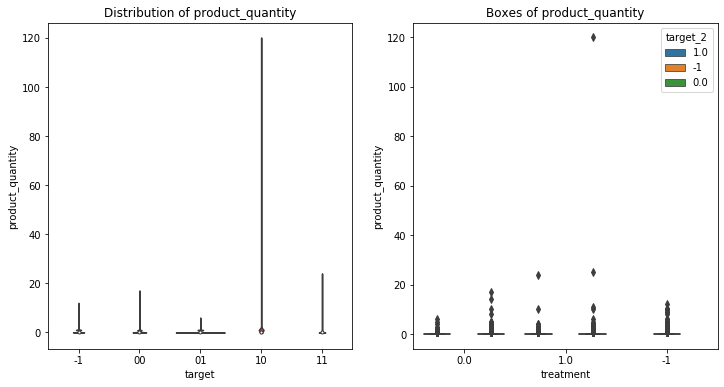

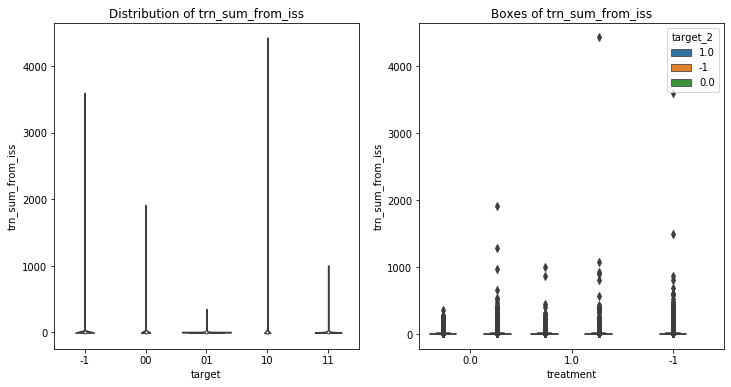

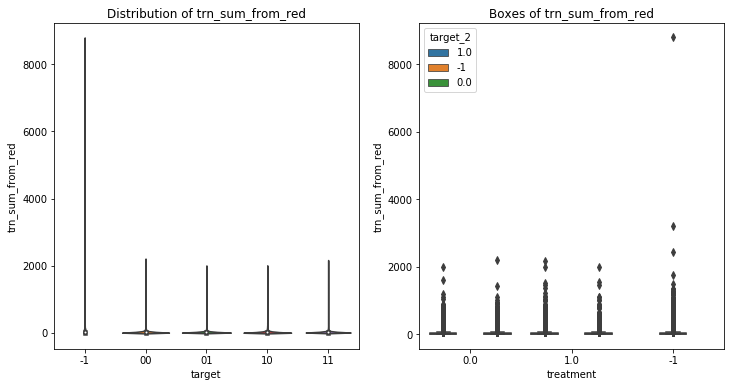

In [334]:
for feat in basic_columns:
    plot_num_target(feat)

In [335]:
df_agg = purchases.df.groupby('client_id')[basic_columns].max()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)
df_agg.head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red,target,target_2,treatment
client_id,,,,,,,,,,,
000012768d,10.000000,0.0,0.0,0.0,1007.000000,4.0,170.0,NaN,01,1,0
000036f903,7.000000,60.0,0.0,0.0,700.000000,4.0,367.0,NaN,11,1,1
000048b7a6,11.200000,0.0,0.0,0.0,1204.000000,3.0,300.0,NaN,-1,-1,-1
000073194a,17.200001,0.0,0.0,0.0,1728.750000,7.0,550.0,35.0,-1,-1,-1
00007c7133,10.400000,0.0,0.0,0.0,1043.839966,3.0,674.0,250.0,-1,-1,-1


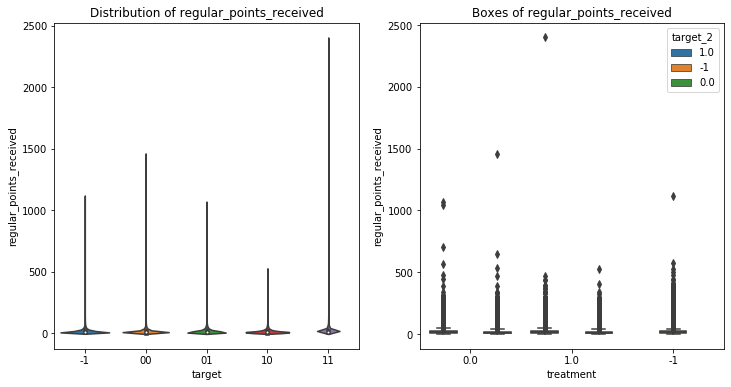

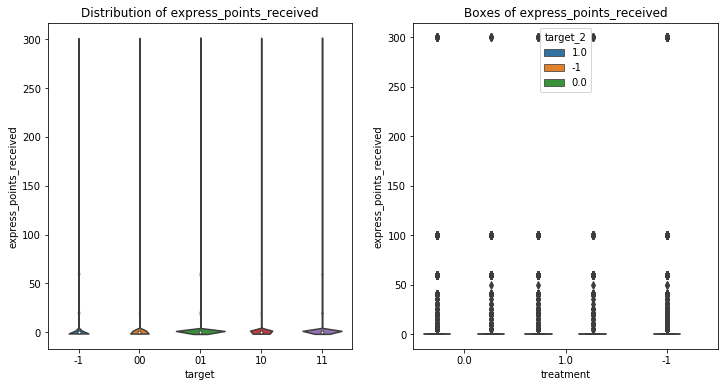

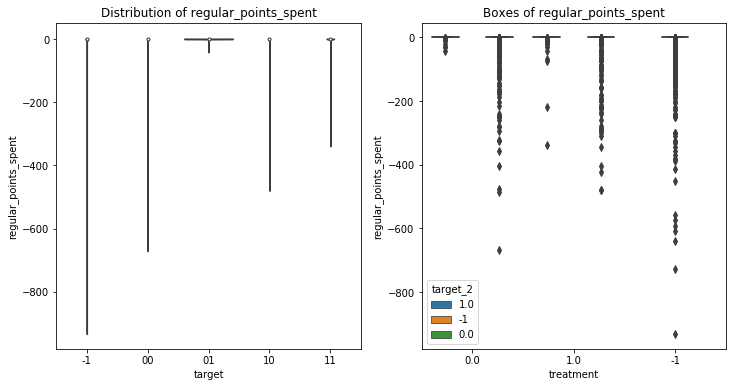

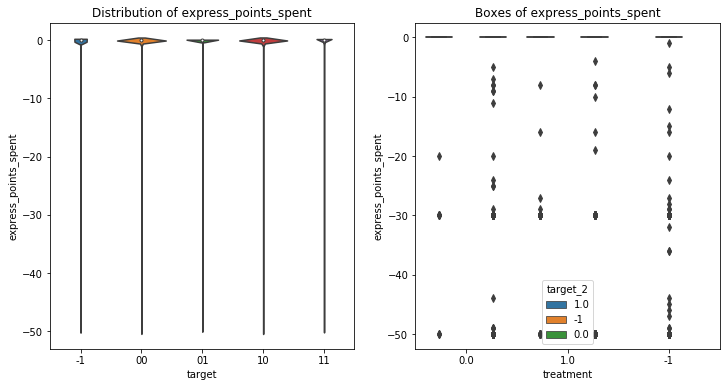

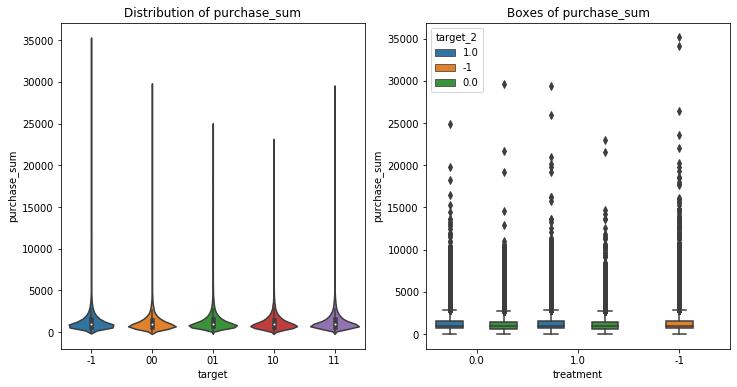

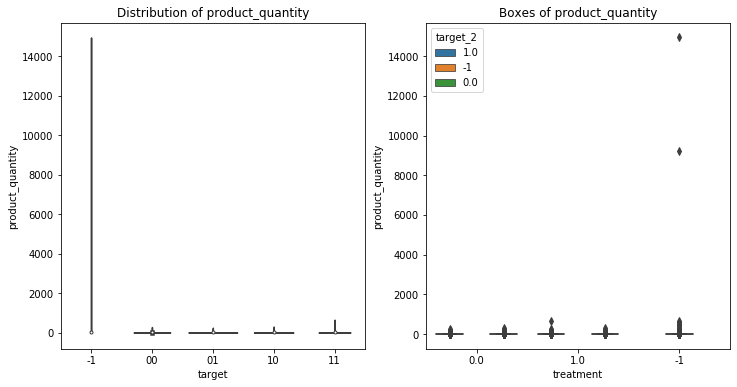

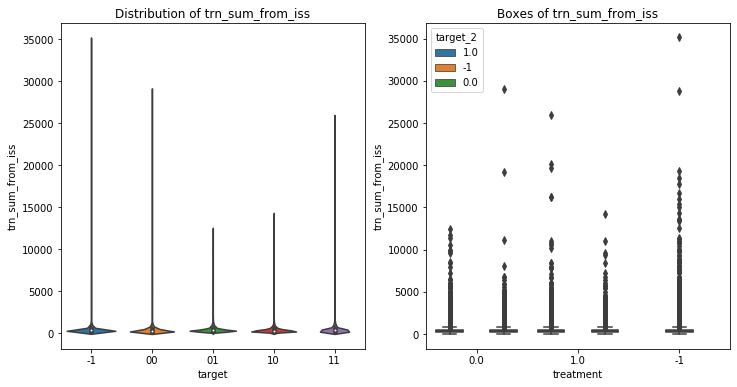

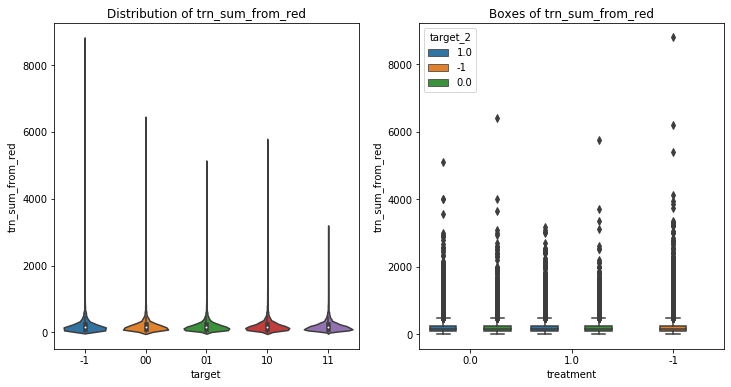

In [336]:
for feat in basic_columns:
    plot_num_target(feat)

In [337]:
df_agg = purchases.df.groupby('client_id')[basic_columns].min()
df_agg['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg['target'].fillna("-1", inplace=True)
df_agg['target_2'] = target['target']
df_agg['treatment'] = target['treatment_flg']
df_agg['target_2'].fillna("-1", inplace=True)
df_agg['treatment'].fillna("-1", inplace=True)

df_agg_1 = purchases.df.groupby('client_id')[basic_columns].max()
df_agg_1['target'] = target['treatment_flg'].astype(str) + target['target'].astype(str)
df_agg_1['target'].fillna("-1", inplace=True)
df_agg_1['target_2'] = target['target']
df_agg_1['treatment'] = target['treatment_flg']
df_agg_1['target_2'].fillna("-1", inplace=True)
df_agg_1['treatment'].fillna("-1", inplace=True)


for feat in basic_columns:
    df_agg[feat] = df_agg_1[feat] - df_agg[feat]

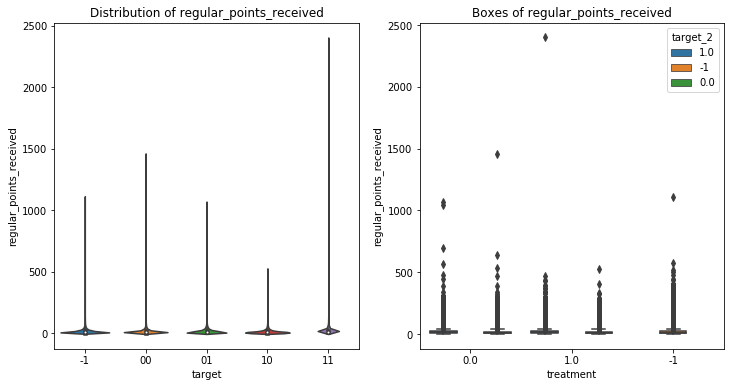

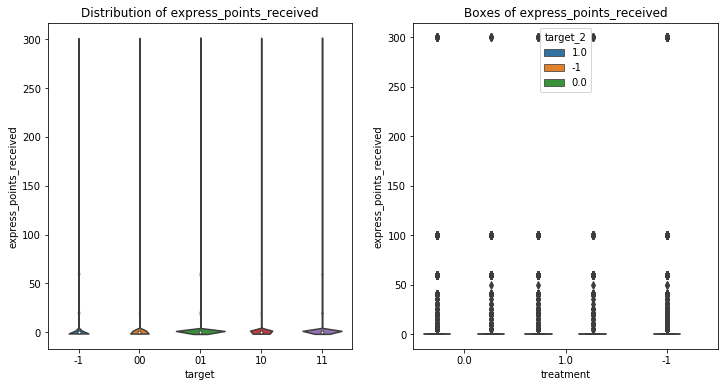

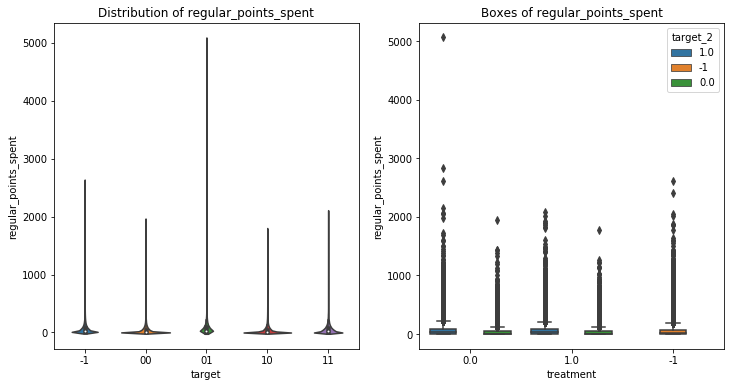

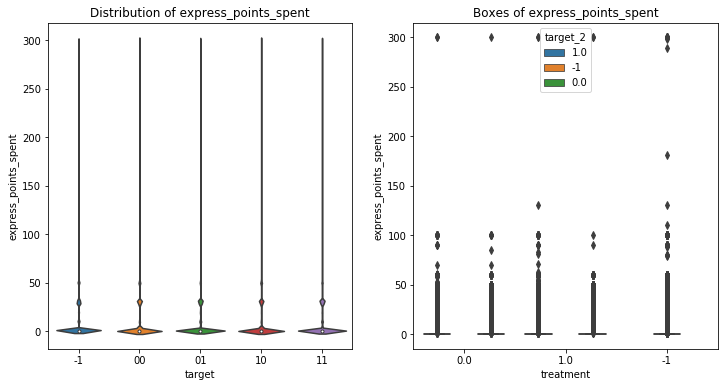

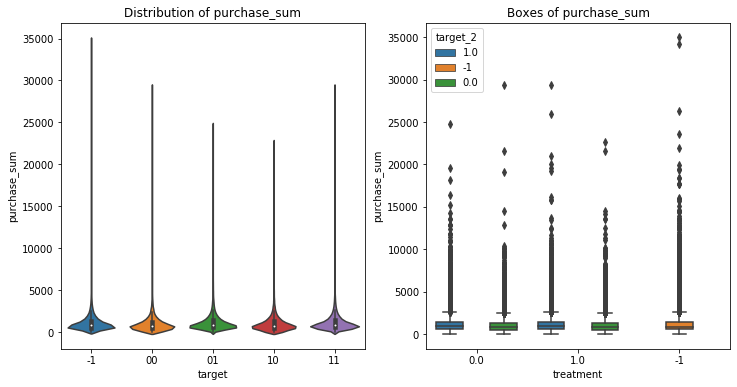

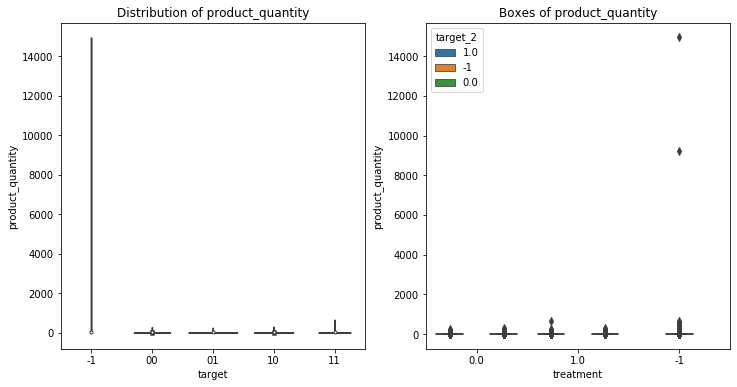

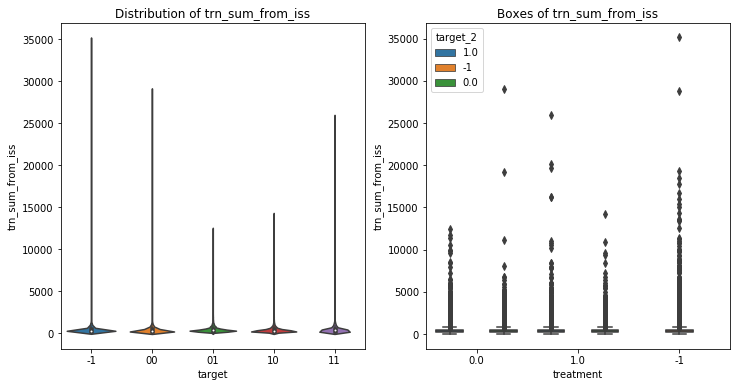

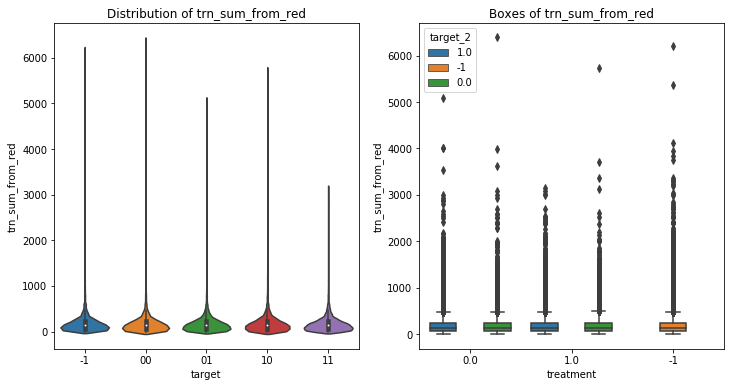

In [338]:
for feat in basic_columns:
    plot_num_target(feat)